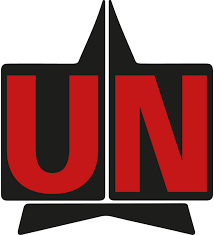

# **Final Project**

## Team #2


1.   Arnaldo Benavides
2.   Santiago Poveda
3.   Nicolás Poveda
4.   Michael Valero
5.   Donny Escolar

In [ ]:
import pandas as pd
from urllib.request import urlopen
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix,accuracy_score

We load the dataset from Datos Abiertos rep:\
https://www.datos.gov.co/Salud-y-Protecci-n-Social/Casos-positivos-de-COVID-19-en-Colombia/gt2j-8ykr/data

In [ ]:
url = "https://www.datos.gov.co/resource/gt2j-8ykr.json"
response = urlopen(url)
data_json = json.loads(response.read())
df_covid = pd.json_normalize(data_json)

df_covid.head(5)

,fecha_reporte_web,id_de_caso,fecha_de_notificaci_n,departamento,departamento_nom,ciudad_municipio,ciudad_municipio_nom,edad,unidad_medida,sexo,fuente_tipo_contagio,ubicacion,estado,pais_viajo_1_cod,pais_viajo_1_nom,recuperado,fecha_inicio_sintomas,fecha_diagnostico,fecha_recuperado,tipo_recuperacion,per_etn_,nom_grupo_,fecha_muerte
0,6/3/2020 0:00:00,1,2/3/2020 0:00:00,11,BOGOTA,11001,BOGOTA,19,1,F,Importado,Casa,Leve,380,ITALIA,Recuperado,27/2/2020 0:00:00,6/3/2020 0:00:00,13/3/2020 0:00:00,PCR,6,NaN,NaN
1,9/3/2020 0:00:00,2,6/3/2020 0:00:00,76,VALLE,76111,BUGA,34,1,M,Importado,Casa,Leve,724,ESPAÑA,Recuperado,4/3/2020 0:00:00,9/3/2020 0:00:00,19/3/2020 0:00:00,PCR,5,NaN,NaN
2,9/3/2020 0:00:00,3,7/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,50,1,F,Importado,Casa,Leve,724,ESPAÑA,Recuperado,29/2/2020 0:00:00,9/3/2020 0:00:00,15/3/2020 0:00:00,PCR,6,NaN,NaN
3,11/3/2020 0:00:00,4,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,55,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,6/3/2020 0:00:00,11/3/2020 0:00:00,26/3/2020 0:00:00,PCR,6,NaN,NaN
4,11/3/2020 0:00:00,5,9/3/2020 0:00:00,5,ANTIOQUIA,5001,MEDELLIN,25,1,M,Relacionado,Casa,Leve,NaN,NaN,Recuperado,8/3/2020 0:00:00,11/3/2020 0:00:00,23/3/2020 0:00:00,PCR,6,NaN,NaN


In [ ]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   fecha_reporte_web      1000 non-null   object
 1   id_de_caso             1000 non-null   object
 2   fecha_de_notificaci_n  1000 non-null   object
 3   departamento           1000 non-null   object
 4   departamento_nom       1000 non-null   object
 5   ciudad_municipio       1000 non-null   object
 6   ciudad_municipio_nom   1000 non-null   object
 7   edad                   1000 non-null   object
 8   unidad_medida          1000 non-null   object
 9   sexo                   1000 non-null   object
 10  fuente_tipo_contagio   1000 non-null   object
 11  ubicacion              1000 non-null   object
 12  estado                 1000 non-null   object
 13  pais_viajo_1_cod       477 non-null    object
 14  pais_viajo_1_nom       477 non-null    object
 15  recuperado            

#Visualization 

conteo de casos positivos hombres vs mujeres

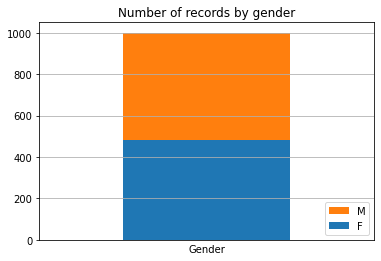

In [ ]:
df_covid.assign(dummy = 1).groupby(
  ['dummy','sexo']
).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)

plt.title('Number of records by gender')

# other it'll show up as 'dummy' 
plt.xlabel('Gender')

# disable ticks in the x axis
plt.xticks([])

# fix the legend
current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)

labels = reversed(df_covid['sexo'].unique())

plt.legend(reversed_handles,labels,loc='lower right')
plt.grid()
plt.show()

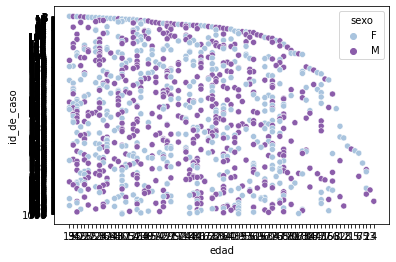

In [ ]:
sns.scatterplot(data=df_covid, x='edad', y='id_de_caso', hue='sexo', palette='BuPu')

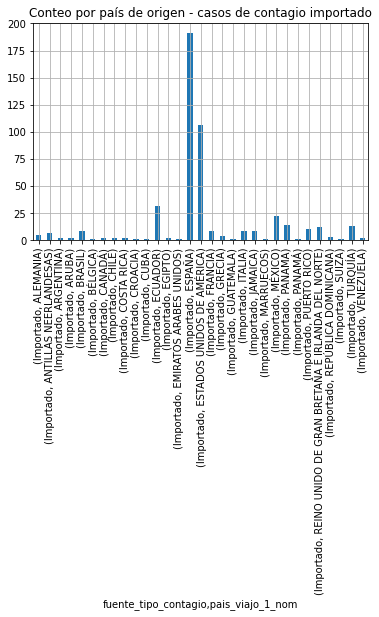

In [ ]:
df_covid.groupby(['fuente_tipo_contagio','pais_viajo_1_nom']).size().plot(kind='bar',stacked=True)
plt.title('Conteo por país de origen - casos de contagio importado')
plt.grid()
plt.show()

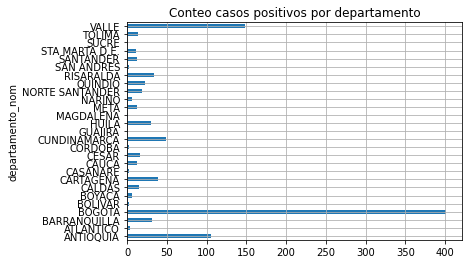

In [ ]:
df_covid.groupby(['departamento_nom']).size().plot(kind='barh',stacked=True)
plt.title('Conteo casos positivos por departamento')
plt.grid()
plt.show()

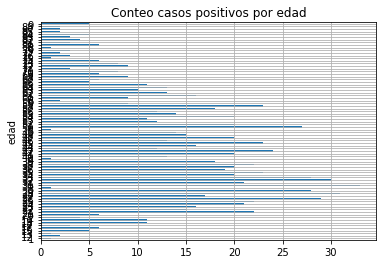

In [ ]:
df_covid.groupby(['edad']).size().plot(kind='barh',stacked=True)
plt.title('Conteo casos positivos por edad')
plt.grid()
plt.show()

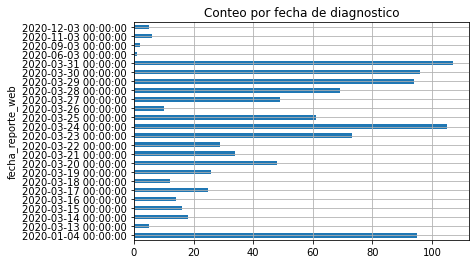

In [ ]:
df_covid["fecha_reporte_web"]=pd.to_datetime(df_covid["fecha_reporte_web"])
df2 = df_covid.sort_values(["fecha_reporte_web"])
df2 = df_covid.groupby('fecha_reporte_web').size().plot(kind='barh',stacked=True)
plt.title('Conteo por fecha de diagnostico')
plt.grid()
plt.show()

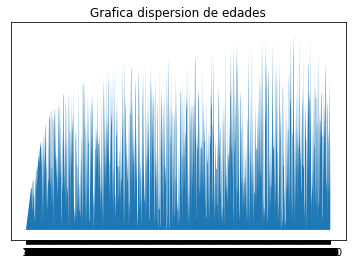

In [ ]:
fig, ax = plt.subplots()
ax.fill_between(df_covid.id_de_caso,df_covid.edad)
plt.gca().axes.get_yaxis().set_visible(False)
plt.title('Grafica dispersion de edades')
plt.show()

#Machine learning Models


##Linear regression

### Cross Validation

1.  Split your data in two sets (training set (70%) and validation set (30%)).

2. Fit your model with your training data.

3. Validate (test) your model with your validation test.

4. **You can repeat this process to get stats of your model**

Aquí se divide el set y se toma como si la ciudad_municipio de los casos positivos dependiera del departamento y de la edad, para ver si existe relación y el score del modelo lineal

In [ ]:
y = df_covid[['ciudad_municipio']].values.astype(np.float32)
X = df_covid[['departamento','edad']].values.astype(np.float32);

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
lr = LinearRegression(fit_intercept=False);

#We train with _train
lr_fit = lr.fit(X_train, y_train);

#We validate with _test
lr_score = lr_fit.score(X_test, y_test);

print(f'* Score of linear model for covid data set {lr_score}');


* Score of linear model for covid data set -0.15975735032645044


### Repeat the process

In [ ]:
N = 5000;
scores = [];
alphas = [];
for i in range(0, N):
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=i+4);
  lr = LinearRegression(fit_intercept=False);
  lr_fit = lr.fit(X_train, y_train);
  lr_score = lr_fit.score(X_test, y_test);
  scores.append(lr_score);
  alphas.append(lr_fit.coef_[0]);
scores = np.array(scores, dtype=np.float32);
alphas = np.array(alphas, dtype=np.float32);

In [ ]:
sns.kdeplot(scores, shade=True)

## Logistic Model


* To build a model of `sexo` as a function of `edad` and `departamento`.

* Note that, `sexo` is a categorical variable - this is a problem of **classification**

\begin{eqnarray}
\text{Sexo} = \frac{1}{1+ \exp \left ( -(a_1 \cdot \text{Departamento}+ a_2 \cdot \text{Edad} + a_0) ) \right)} + \epsilon
\end{eqnarray}

In [ ]:
from sklearn.linear_model import LogisticRegression
datos = df_covid.values
y_logi = datos[:,-14];
X_logi = df_covid[['departamento','edad']].values.astype(np.float32)
X_tra, X_test, y_tra, y_test = train_test_split(X_logi, y_logi, test_size=0.3, random_state=10);


In [ ]:
U,S,V = np.linalg.svd(X_logi, full_matrices=False);

### Projection

#### One dimensional projection

Información explicada $\frac{\sigma_1}{\sum_i \sigma_i}$

In [ ]:
sns.set_style('darkgrid')
sns.kdeplot(U[:,0], shade=True, color='red')
print(f'Información explicada = {round(S[0]/np.sum(S)*100)}%');

#### Two dimensional projection

Información explicada $\frac{\sigma_1 + \sigma_2}{\sum_i \sigma_i}$

In [ ]:
sns.kdeplot(x=U[:,0],y = U[:,1],shade=True,color='purple')
print(f'Información explicada = {round((S[0]+S[1])/np.sum(S)*100)}%');

In [ ]:
sns.scatterplot(x=U[:,0],y = U[:,1])
print(f'Información explicada = {round((S[0]+S[1])/np.sum(S)*100)}%');

###1. Train the model

In [ ]:
lr = LogisticRegression(solver='liblinear');
lr_fit = lr.fit(X_tra, y_tra);

###2. Validation

In [ ]:
lr_fit.score(X_test,y_test)

0.5

###3. Further comments

In [ ]:
lr_fit.coef_

array([[-1.33981736e-05,  2.19126495e-03]])

In [ ]:
lr_fit.intercept_

array([4.40332112e-05])

In [ ]:
ma_fe = lr_fit.predict(X_test)
ma_fe

array(['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'F',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M',
       'M', 'F', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'M',
       'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M',
       'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M

Usamos la **matriz de confusión** y la **puntuación de precisión** comparando los valores de prueba predichos y reales

In [ ]:
cm = confusion_matrix(y_test, ma_fe)
ac = accuracy_score(y_test, ma_fe)
cm

array([[  7, 136],
       [ 14, 143]])

In [ ]:
ac

0.5

De nuevo, se obtuvo un porcentaje del 50% con este modelo ♥

In [ ]:
lr_fit.predict_proba(X_test)

array([[0.48638069, 0.51361931],
       [0.47506471, 0.52493529],
       [0.49531335, 0.50468665],
       [0.46175356, 0.53824644],
       [0.48414448, 0.51585552],
       [0.46523948, 0.53476052],
       [0.48252963, 0.51747037],
       [0.47506471, 0.52493529],
       [0.45967569, 0.54032431],
       [0.46668527, 0.53331473],
       [0.48862415, 0.51137585],
       [0.62306783, 0.37693217],
       [0.48381473, 0.51618527],
       [0.47440136, 0.52559864],
       [0.48140866, 0.51859134],
       [0.46229821, 0.53770179],
       [0.48318051, 0.51681949],
       [0.48308014, 0.51691986],
       [0.48195574, 0.51804426],
       [0.48490929, 0.51509071],
       [0.465568  , 0.534432  ],
       [0.46519615, 0.53480385],
       [0.48140866, 0.51859134],
       [0.4721362 , 0.5278638 ],
       [0.48686118, 0.51313882],
       [0.46012014, 0.53987986],
       [0.4898264 , 0.5101736 ],
       [0.48964561, 0.51035439],
       [0.48523909, 0.51476091],
       [0.48359724, 0.51640276],
       [0.

###Repeat the process
Se aplica el mismo proceso 5k veces para tener stacks

In [ ]:
N = 5000;
scores = [];
alphas = [];
for i in range(0, N):
  X_tra, X_test, y_tra, y_test = train_test_split(X_logi, y_logi, test_size=0.3, random_state=i+4);
  lr = LogisticRegression(solver='liblinear',fit_intercept=False);
  lr_fit = lr.fit(X_tra, y_tra);
  lr_score = lr_fit.score(X_test, y_test);
  scores.append(lr_score);
  alphas.append(lr_fit.coef_[0]);
scores = np.array(scores, dtype=np.float32);
alphas = np.array(alphas, dtype=np.float32);

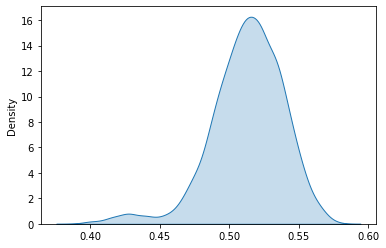

In [ ]:
sns.kdeplot(scores, shade=True)

Se puede ver como la probabilidad de la varible categorica dependiente `sexo` como funcion de la `edad` y el `departamento` tiene un score de un poco más 50% de las veces en este modelo

##Naive Bayes

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB

Partimos nuestros datos y realizaremos un escalado de características al conjunto de entrenamiento y prueba.

In [ ]:
y_NB = df_covid[['ciudad_municipio']].values.astype(np.float32)
X_NB = df_covid[['departamento','edad']].values.astype(np.float32);
X_train, X_test, y_train, y_test = train_test_split(X_NB, y_NB, test_size=0.3, random_state=10)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Entrenamiento del modelo **Naive Bayes** en el set de entrenamiento

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GaussianNB()

###Predicción

In [ ]:
y_pred  =  classifier.predict(X_test)
y_pred

array([25754., 76001., 76001., 11001., 11001., 76001., 19001., 76001.,
       41001., 19001., 41001., 47001., 76001., 41001., 11001., 11001.,
       50001., 20001., 11001., 76001., 11001., 63001., 11001., 17001.,
        5376., 11001., 73001., 19001., 11001., 11001., 11001., 11001.,
       13001.,  5001., 11001., 73001., 76001., 73001., 11001., 41001.,
       25214., 52001., 76001., 11001., 11001., 11001., 73001., 11001.,
       25473., 20001., 66001., 11001.,  5001., 25817., 25769., 76001.,
       11001.,  5001.,  8001., 11001., 11001., 41001., 11001., 76001.,
       13001., 76001., 11001., 11001., 76001., 11001., 11001., 19001.,
       11001., 76001.,  5001., 11001., 11001., 50001., 19001., 11001.,
       11001.,  5001.,  8758., 11001., 66001., 25214., 11001., 11001.,
       11001., 17873., 11001., 11001., 11001., 54001., 11001., 54001.,
       76001., 66001., 50001., 11001.,  5001., 11001., 41001., 11001.,
        5001., 76001., 13001., 11001., 11001., 68276., 11001., 13001.,
      

In [ ]:
y_test

array([[25126.],
       [76001.],
       [76520.],
       [11001.],
       [11001.],
       [76001.],
       [19001.],
       [76001.],
       [41001.],
       [19001.],
       [41001.],
       [47001.],
       [76001.],
       [41001.],
       [11001.],
       [11001.],
       [50001.],
       [20001.],
       [11001.],
       [76001.],
       [11001.],
       [63001.],
       [11001.],
       [17174.],
       [ 5001.],
       [11001.],
       [73001.],
       [19698.],
       [11001.],
       [11001.],
       [11001.],
       [11001.],
       [13001.],
       [ 5001.],
       [11001.],
       [73001.],
       [76001.],
       [73001.],
       [11001.],
       [41001.],
       [25290.],
       [52835.],
       [76892.],
       [11001.],
       [11001.],
       [11001.],
       [73001.],
       [11001.],
       [25473.],
       [20001.],
       [66170.],
       [11001.],
       [ 5615.],
       [25754.],
       [25513.],
       [76001.],
       [11001.],
       [ 5001.],
       [ 8001.

Usamos la **matriz de confusión** y la **puntuación de precisión** comparando los valores de prueba predichos y reales

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
cm

array([[16,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 2,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [ ]:
ac

0.7666666666666667

se obtuvo un buen porcentaje del 76% con este modelo ♥